In [100]:
# ATTENTION: Please do not alter any of the provided code in the exercise. Only add your own code where indicated
# ATTENTION: Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position.
# ATTENTION: Please use the provided epoch values when training.

import csv
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import getcwd

In [103]:
def get_data(filename):
  # You will need to write code that will read the file passed
  # into this function. The first line contains the column headers
  # so you should ignore it
  # Each successive line contians 785 comma separated values between 0 and 255
  # The first value is the label
  # The rest are the pixel values for that picture
  # The function will return 2 np.array types. One with all the labels
  # One with all the images
  #
  # Tips: 
  # If you read a full line (as 'row') then row[0] has the label
  # and row[1:785] has the 784 pixel values
  # Take a look at np.array_split to turn the 784 pixels into 28x28
  # You are reading in strings, but need the values to be floats
  # Check out np.array().astype for a conversion

    with open(filename) as training_file:
      # Your code starts here
        images = []
        labels = []
        lines = training_file.readlines()[1:]

        for line in lines:
            row = line.replace('\n', '').split(',')
            labels.append(row[0])
            images.append(
                np.array(
                    np.array_split(row[1:785], 28)
                ).astype(np.float32)
            )
            row = training_file.readline()
        images = np.array(images)
        labels = np.array(labels).astype(np.float32)
      # Your code ends here
    return images, labels

path_sign_mnist_train = f"{getcwd()}/../tmp2/sign_mnist_train.csv"
path_sign_mnist_test = f"{getcwd()}/../tmp2/sign_mnist_test.csv"
training_images, training_labels = get_data(path_sign_mnist_train)
testing_images, testing_labels = get_data(path_sign_mnist_test)

# Keep these
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

# Their output should be:
# (27455, 28, 28)
# (27455,)
# (7172, 28, 28)
# (7172,)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [104]:
# In this section you will have to add another dimension to the data
# So, for example, if your array is (10000, 28, 28)
# You will need to make it (10000, 28, 28, 1)
# Hint: np.expand_dims

training_images = np.expand_dims(training_images, axis=-1)
testing_images = np.expand_dims(testing_images, axis=-1)

"""
binarizer = LabelBinarizer()
training_labels = binarizer.fit_transform(training_labels)
testing_labels = binarizer.transform(testing_labels)
"""

# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow(
                training_images,
                training_labels,
                batch_size=32)


validation_datagen = ImageDataGenerator(
    rescale=1./255.)

valid_generator = validation_datagen.flow(
                testing_images,
                testing_labels, 
                batch_size=32)
    
# Keep These
print(training_images.shape)
print(testing_images.shape)
    
# Their output should be:
# (27455, 28, 28, 1)
# (7172, 28, 28, 1)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [109]:
# Define the model
# Use no more than 2 Conv2D and 2 MaxPooling2D
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='tanh'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='tanh'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='tanh'),
    tf.keras.layers.Dense(25, activation='softmax')
])

# Compile Model. 
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

class MinAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.3:
            self.model.stop_training = True
min_accuracy_cb = MinAccuracyCallback()

# Train the Model
history = model.fit_generator(
            train_generator,
            epochs=10,
            validation_data=valid_generator,
            callbacks=[min_accuracy_cb])

model.evaluate(valid_generator, verbose=0)

Epoch 1/10
858/858 [==============================] - 68s 80ms/step - loss: 3.0008 - acc: 0.1148 - val_loss: 2.4491 - val_acc: 0.3183
Epoch 2/10
858/858 [==============================] - 68s 79ms/step - loss: 2.6411 - acc: 0.2145 - val_loss: 2.2470 - val_acc: 0.2835
Epoch 3/10
858/858 [==============================] - 69s 80ms/step - loss: 2.4300 - acc: 0.2693 - val_loss: 1.7948 - val_acc: 0.4492
Epoch 4/10
858/858 [==============================] - 69s 81ms/step - loss: 2.3030 - acc: 0.3022 - val_loss: 1.7264 - val_acc: 0.4926


[1.723380036883884, 0.49261016]

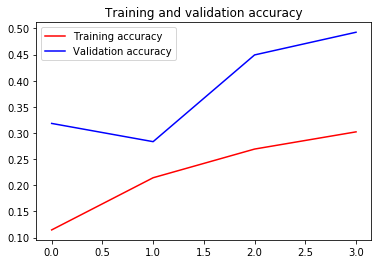

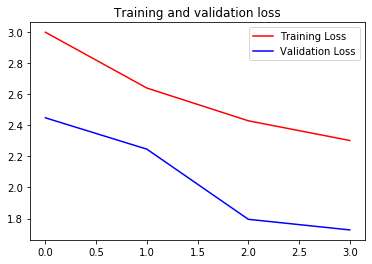

In [110]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Submission Instructions

In [111]:
# Now click the 'Submit Assignment' button above.

# When you're done or would like to take a break, please run the two cells below to save your work and close the Notebook. This will free up resources for your fellow learners. 

In [ ]:
%%javascript
<!-- Save the notebook -->
IPython.notebook.save_checkpoint();

In [ ]:
%%javascript
IPython.notebook.session.delete();
window.onbeforeunload = null
setTimeout(function() { window.close(); }, 1000);